<center><h1>Explore Vaccines Tweets - proxy+Labelled data_data_imbalance
   
   </h1></center>

# Introduction


The Dataset we are using here is collected using Twitter API, **tweepy** and Python package.

The following vaccines are included:  
* Pfizer/BioNTech;   
* Sinopharm;  
* Sinovac;  
* Moderna;  
* Oxford/AstraZeneca;   
* Covaxin;   
* Sputnik V.  



# Data preparation

## Load packages

In [228]:
! pip install tensorflow==2.6 tensorflow-gpu==2.6  tensorflow-estimator==2.6.0 seaborn  lightgbm   pandas plotly  matplotlib nltk numpy gensim wordcloud textblob neattext scikit_learn nbformat transformers tensorflow_hub bert-tensorflow  tf-models-official keras==2.6.0 imblearn

In [229]:
#! pip install tensorflow==2.6
import tensorflow as tf
tf.__version__



'2.6.0'

In [230]:
import numpy as np 
import pandas as pd
import matplotlib as mp
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
%matplotlib inline 
from wordcloud import WordCloud, STOPWORDS
##
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
##
import warnings
warnings.simplefilter("ignore")

## Load data

In [231]:
#tweets_proxy_df = pd.read_csv("tweets_unlabelled_1L_proxy_labels.csv", encoding='utf-8')
train_labelled_df= pd.read_csv("clean_tweets_labelled_train.csv", encoding='utf-8')

In [232]:
#tweets_df=tweets_proxy_df.append(train_labelled_df)

In [233]:
#tweets_df.to_csv('tweets_combined_proxy+label.csv', encoding='utf-8', index=False)

In [234]:
tweets_df = pd.read_csv("tweets_combined_proxy+label.csv", encoding='utf-8')

In [235]:
len(tweets_df)

99147

# Data exploration


## Glimpse the data

In [236]:
print(f"data shape: {tweets_df.shape}")

data shape: (99147, 2)


In [237]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99147 entries, 0 to 99146
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   clean_data  98289 non-null  object
 1   label       99147 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [238]:
tweets_df.describe()

,label
count,99147.00000
mean,1.09029
std,0.29741
min,0.00000
25%,1.00000
50%,1.00000
75%,1.00000
max,2.00000


In [239]:
tweets_df.head()

,clean_data,label
0,folks said daikon paste could treat cytokine s...,1
1,world wrong side history year hopefully bigges...,1
2,russian vaccine created last 24 years,1
3,explain need vaccine,1
4,anyone useful adviceguidance whether covid vac...,1


### Missing data

In [240]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [241]:
missing_data(tweets_df)

,clean_data,label
Total,858,0
Percent,0.865382,0.0
Types,object,int64


In [242]:
missed = pd.DataFrame()
missed['column'] = tweets_df.columns
missed['percent'] = [round(100* tweets_df[col].isnull().sum() / len(tweets_df), 2) for col in tweets_df.columns]
missed = missed.sort_values('percent',ascending=False)
missed = missed[missed['percent']>0]
print(missed)
#fig = sns.barplot(
#    x=missed['percent'], 
#    y=missed["column"], 
#    orientation='horizontal'
#).set_title('Missed values percent for every column')

       column  percent
0  clean_data     0.87


### Unique values

In [243]:
def unique_values(data):
    total = data.count()
    tt = pd.DataFrame(total)
    tt.columns = ['Total']
    uniques = []
    for col in data.columns:
        unique = data[col].nunique()
        uniques.append(unique)
    tt['Uniques'] = uniques
    return(np.transpose(tt))

In [244]:
unique_values(tweets_df)

,clean_data,label
Total,98289,99147
Uniques,88360,3


### Most frequent values

In [245]:
def most_frequent_values(data):
    total = data.count()
    tt = pd.DataFrame(total)
    tt.columns = ['Total']
    items = []
    vals = []
    for col in data.columns:
        itm = data[col].value_counts().index[0]
        val = data[col].value_counts().values[0]
        items.append(itm)
        vals.append(val)
    tt['Most frequent item'] = items
    tt['Frequence'] = vals
    tt['Percent from total'] = np.round(vals / total * 100, 3)
    return(np.transpose(tt))

In [246]:
most_frequent_values(tweets_df)

,clean_data,label
Total,98289,99147
Most frequent item,vaccinated,1
Frequence,129,89569
Percent from total,0.131,90.34


## Visualize the data distribution

### Tweet source

In [247]:
#plot heatmap to see the correlation between features
#plt.subplots(figsize=(9, 9))
#sns.heatmap(tweets_df.corr(), annot=True, square=True)
#plt.show()

In [248]:

labels = tweets_df.groupby('label').count()['clean_data'].reset_index().sort_values(by='label',ascending=True)
labels.style.background_gradient(cmap='gist_earth_r')

,label,clean_data
0,0,313
1,1,88713
2,2,9263


In [249]:

labels = train_labelled_df.groupby('label').count()['clean_data'].reset_index().sort_values(by='label',ascending=True)
labels.style.background_gradient(cmap='gist_earth_r')

,label,clean_data
0,0,263
1,1,2584
2,2,1348


In [250]:


#labels = tweets_proxy_df.groupby('label').count()['clean_data'].reset_index().sort_values(by='label',ascending=True)
#labels.style.background_gradient(cmap='gist_earth_r')

<AxesSubplot:xlabel='label', ylabel='count'>

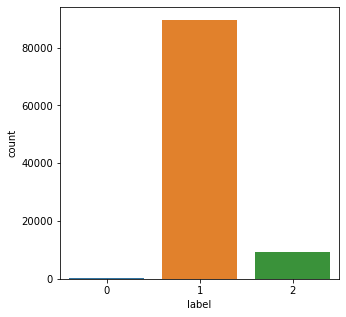

In [251]:
plt.figure(figsize=(5,5))
sns.countplot(x='label',data=tweets_df)


In [252]:
#plt.figure(figsize=(5,5))
#sns.countplot(x='label',data=train_labelled_df)


In [253]:
#plt.figure(figsize=(5,5))
#sns.countplot(x='label',data=tweets_proxy_df)

In [254]:
fig = go.Figure(go.Funnelarea( text =labels.label,
    values = labels.clean_data,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

### Handling data imbalance





In [255]:
df_0_label=tweets_df.loc[tweets_df['label'] == 0]
df_1_label=tweets_df.loc[tweets_df['label'] == 1]
df_2_label=tweets_df.loc[tweets_df['label'] == 2]

In [256]:
trained_labeled_df_0_label=train_labelled_df.loc[tweets_df['label'] == 0]
trained_labeled_df_1_label=train_labelled_df.loc[tweets_df['label'] == 1]
trained_labeled_df_2_label=train_labelled_df.loc[tweets_df['label'] == 2]

In [257]:
#Approch 1
#df_1_label=df_1_label.head(5000)
#df_2_label=df_2_label.head(5000)

# approch 2
# Get the differneces from proxy for making it around 10k + ( 5kl1, 5k l2 and l0 full)
df_0_label=df_0_label.head(313-263)
df_1_label=df_1_label.head(5000-2587)
df_2_label=df_2_label.head(5000-1350)

#df_0_label

In [258]:
df_1_label

,clean_data,label
0,folks said daikon paste could treat cytokine s...,1
1,world wrong side history year hopefully bigges...,1
2,russian vaccine created last 24 years,1
3,explain need vaccine,1
4,anyone useful adviceguidance whether covid vac...,1
...,...,...
2598,feeling good,1
2599,think vaccine question different,1
2600,covid19 vaccine pfizer biontech ingredients look,1
2602,dr marc siegel speeding covid vaccinations bid...,1


In [259]:
df_2_label

,clean_data,label
33,vaccine anyone,2
44,dairy dose dumbsville,2
76,first us covid19 vaccinations today thank ever...,2
86,half way,2
96,received first dose today feel privileged amp ...,2
...,...,...
41289,got first dose covid19 vaccine morning slept d...,2
41300,love much,2
41311,got first dose afternoon far feel fine side ef...,2
41318,got jab 1 workout icing case ibuprofen bed far...,2


In [260]:
train= pd.concat([trained_labeled_df_0_label,trained_labeled_df_1_label,trained_labeled_df_2_label,df_0_label,df_1_label,df_2_label])

In [261]:
# seperate off train and test
#train = tweets_df.iloc[40000:, :]
#test = tweets_df.iloc[14469:, :]
#train = tweets_df.sample(frac=0.7,random_state=200)
print(len(train))
#test=tweets_df.drop(train.index)
#print(len(test))


10313



### Classification Tasks

In [262]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#import gensim

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix,recall_score,precision_score,make_scorer
from sklearn.model_selection import StratifiedKFold, train_test_split, learning_curve,cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from statistics import mean, stdev
import lightgbm as lgb
import joblib

# target variable 
y = train["label"].values

no_of_splits=5
# initializing Kfold
skf = StratifiedKFold(n_splits=no_of_splits, shuffle=True, random_state=24)

# count vectorizer transformation
count_vect = CountVectorizer(max_features=15000)
count_vect.fit(tweets_df["clean_data"].values.astype('U').tolist())
train_count_vect = count_vect.transform(train["clean_data"].values.astype('U'))
joblib.dump(count_vect, "model/vectors/count_vect_proxy_labelled4.pkl")

# tfidf vectorizer transformation 
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(tweets_df["clean_data"].values.astype('U').tolist())
train_tfidf_vect = tfidf_vect.transform(train["clean_data"].values.astype('U'))
joblib.dump(tfidf_vect, "model/vectors/_tfidf_vect_proxy_labelled4.pkl")


['model/vectors/_tfidf_vect_proxy_labelled4.pkl']

In [263]:

from imblearn.over_sampling import ADASYN
from collections import Counter
print('Original Target Variable Distribution:', Counter(train["label"]))
ada = ADASYN(random_state=130)

X_resampled, y_resampled = ada.fit_resample(train_tfidf_vect,  train["label"])
X_resampled1, y_resampled1 = ada.fit_resample(train_count_vect,  train["label"])

print('Original Target Variable Distribution:', Counter(y_resampled))
#print(type(X_resampled.shape[0]))
#print(len(y_resampled))

#print(y_resampled.shape[0])

y = y_resampled
train_tfidf_vect=X_resampled
#train_count_vect=X_resampled1
y

Original Target Variable Distribution: Counter({1: 5000, 2: 5000, 0: 313})
Original Target Variable Distribution: Counter({1: 5000, 2: 5000, 0: 4977})


0        1
1        2
2        1
3        0
4        1
        ..
14972    0
14973    0
14974    0
14975    0
14976    0
Name: label, Length: 14977, dtype: int64

In [264]:
train_count_vect

<10313x15000 sparse matrix of type '<class 'numpy.int64'>'
	with 85827 stored elements in Compressed Sparse Row format>

In [265]:
train_tfidf_vect 

<14977x49591 sparse matrix of type '<class 'numpy.float64'>'
	with 183995 stored elements in Compressed Sparse Row format>

In [266]:

# light gbm parameters
lgbm_params = {
    "learning_rate": 0.02, 
    "random_state": 24, 
    "metric": "multi_logloss",
    "n_estimators": 2000,
    "objective": "multiclass"
}
# models
models =  {
    "svm": SVC(),
    "logistic_regression": LogisticRegression(),
    "naive_bayes": MultinomialNB(),
    "SGD": SGDClassifier(),
    "random_forest": RandomForestClassifier(class_weight='balanced'),
    #"BernoulliNB": BernoulliNB(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "LGBM":lgb.LGBMClassifier(**lgbm_params)
    
} 

# current vectors
vectors = {
  #  "count_vectorizer": train_count_vect,
    "tfidf_vectorizer": train_tfidf_vect
}

In [267]:
def stratified_kfold(clf:str, vect_type:str, y, kfold):
    """
    Perform Kfold Cross-Validation
    :param model: the model used to make predictions
    :param X: the train features being used 
    :param y: the target feature,
    :param kfold: the cross validation strategy
    :return: dictionary with model name key and results as the values
    """
    results = {}
    # store the name of the model in dictionary
    results["modelname_vectorType"] = clf + "_" + vect_type
    
    # call the model and training data
    model = models[clf]
    X = vectors[vect_type]

    f1score_list= []
    lst_accu_stratified = []
    # perfrom kfold cv
    for fold, (train_idx, valid_idx) in enumerate(kfold.split(X, y)):
        #print(f"\nCurrently Training: {results['modelname_vectorType']}... Fold: {fold+1}")
        X_train, X_valid = X[train_idx], X[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        
        # train on seen data, predict on unseen
        model.fit(X_train, y_train)
        y_preds = model.predict(X_valid)
        f1score = f1_score(y_valid, y_preds,average='weighted')
        results["fold_{}".format(fold+1)] = f1score
        lst_accu_stratified.append(model.score(X_valid, y_valid))
        f1score_list.append(f1score)
    results["accuracy"] = "%.3f%%" % (mean(lst_accu_stratified) * 100)
    #results["mean_f1-score"] = "%.3f%%" % (mean(f1score_list)*100)
    joblib.dump(model, "model/"+clf + "_" + vect_type+"4.pkl")
    return results

In [268]:
def stratified_kfold_lbgm(clf:str, vect_type:str, y, kfold):
    """
    Perform Kfold Cross-Validation
    :param model: the model used to make predictions
    :param X: the train features being used 
    :param y: the target feature,
    :param kfold: the cross validation strategy
    :return: dictionary with model name key and results as the values
    """
    results = {}
    # store the name of the model in dictionary
    results["modelname_vectorType"] = clf + "_" + vect_type
    
    # call the model and training data
    model = models[clf]
    X = vectors[vect_type]
    
    f1score_list= []
    lst_accu_stratified = []
    # perfrom kfold cv
    for fold, (train_idx, valid_idx) in enumerate(kfold.split(X, y)):
        print(f"\nCurrently Training: {results['modelname_vectorType']}... Fold: {fold+1}")
        X_train, X_valid= X[train_idx].astype(np.float64), X[valid_idx].astype(np.float64)
        y_train, y_valid= y[train_idx].astype(np.float64), y[valid_idx].astype(np.float64)
        # train on seen data, predict on unseen
        model.fit(X_train,
             y_train,
             eval_set=[(X_valid, y_valid)],
             verbose=100,
             early_stopping_rounds=100)
        
        y_preds = model.predict(X_valid)
        f1score = f1_score(y_valid, y_preds,average='weighted')
        results["fold_{}".format(fold+1)] = f1score
        lst_accu_stratified.append(model.score(X_valid, y_valid))
        f1score_list.append(f1score)


    results["accuracy"] = "%.3f%%" % (mean(lst_accu_stratified) * 100)
    #results["mean_f1-score"] = "%.3f%%" % (mean(f1score_list)*100)
    joblib.dump(model, "model/"+clf + "_" + vect_type+"4.pkl")
    return results

In [269]:
# store all models
all_models = []

for clf in models:
    for vect in vectors:
        if clf == "LGBM":
            
            all_models.append(stratified_kfold_lbgm(clf, vect, y, skf))
        else:
            all_models.append(stratified_kfold(clf, vect, y, skf))            
        print(f"Current Model: {clf}_{vect}...\n")

Current Model: svm_tfidf_vectorizer...

Current Model: logistic_regression_tfidf_vectorizer...

Current Model: naive_bayes_tfidf_vectorizer...

Current Model: SGD_tfidf_vectorizer...

Current Model: random_forest_tfidf_vectorizer...

Current Model: DecisionTreeClassifier_tfidf_vectorizer...

Current Model: KNeighborsClassifier_tfidf_vectorizer...


Currently Training: LGBM_tfidf_vectorizer... Fold: 1
[100]	valid_0's multi_logloss: 0.49426
[200]	valid_0's multi_logloss: 0.388641
[300]	valid_0's multi_logloss: 0.349458
[400]	valid_0's multi_logloss: 0.330457
[500]	valid_0's multi_logloss: 0.319993
[600]	valid_0's multi_logloss: 0.314504
[700]	valid_0's multi_logloss: 0.311617
[800]	valid_0's multi_logloss: 0.310032
[900]	valid_0's multi_logloss: 0.309332
[1000]	valid_0's multi_logloss: 0.309928

Currently Training: LGBM_tfidf_vectorizer... Fold: 2
[100]	valid_0's multi_logloss: 0.468137
[200]	valid_0's multi_logloss: 0.362957
[300]	valid_0's multi_logloss: 0.323043
[400]	valid_0's multi_

In [270]:
models_df = pd.DataFrame(all_models)
models_df

,modelname_vectorType,fold_1,fold_2,fold_3,fold_4,fold_5,accuracy
0,svm_tfidf_vectorizer,0.891694,0.913031,0.905216,0.915407,0.912406,90.779%
1,logistic_regression_tfidf_vectorizer,0.878844,0.895937,0.883030,0.899043,0.895718,89.183%
2,naive_bayes_tfidf_vectorizer,0.807038,0.818652,0.810615,0.821436,0.813845,82.012%
3,SGD_tfidf_vectorizer,0.889185,0.900153,0.888838,0.901936,0.900519,89.724%
4,random_forest_tfidf_vectorizer,0.882479,0.899243,0.898143,0.903682,0.899073,89.678%
5,DecisionTreeClassifier_tfidf_vectorizer,0.833996,0.852222,0.839448,0.848812,0.848867,84.563%
6,KNeighborsClassifier_tfidf_vectorizer,0.601714,0.602789,0.575887,0.621790,0.605528,62.863%
7,LGBM_tfidf_vectorizer,0.875499,0.898165,0.889480,0.892496,0.893249,88.990%


In [ ]:
import tensorflow
tensorflow.__version__

### Word2Vec Embeddings

In [ ]:
train["label"].unique()

In [ ]:
labels = tf.keras.utils.to_categorical(train["label"], dtype="float32")

In [ ]:
labels

In [ ]:
import gensim.downloader as api
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Bidirectional,SpatialDropout1D,GRU,Conv1D,MaxPooling1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers, Sequential


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
max_words = 5000
max_len = 200

n_epochs = 8
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train["clean_data"].values.astype('U'))
sequences = tokenizer.texts_to_sequences(train["clean_data"].values.astype('U'))
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

joblib.dump(tokenizer, "model/vectors/dl_tokenizer2.pkl")

In [ ]:
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(tweets,labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

In [ ]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    


In [ ]:
## LSTM 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import datasets

from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import History

from tensorflow.keras import losses
vocab_size = 5000
embedding_size = 32
epochs=20
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
max_len=50



sgd1 = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model1.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model1.add(MaxPooling1D(pool_size=2))
model1.add(LSTM(15,dropout=0.5))
model1.add(Dense(3,activation='softmax'))

# initializing early stopping 
early_stopping = EarlyStopping(monitor='loss', patience=3)

print(model1.summary())
# Compile model
model1.compile(loss='categorical_crossentropy', optimizer=sgd1, 
               metrics=['accuracy'])

# Train model
batch_size = 64
checkpoint = ModelCheckpoint('model/dl/lstm_best_model2.h5', monitor='val_loss', save_best_only=True)
history1 = model1.fit(X_train, y_train,
                      validation_data=(X_test, y_test),callbacks=[early_stopping,checkpoint],
                      batch_size=batch_size, epochs=epochs, verbose=1)

print('LSTM Best model saved')

In [ ]:
plot_training_hist(history1)

In [ ]:
## BILSTM

sgd2 = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model2= Sequential()
model2.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model2.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Bidirectional(LSTM(32)))
model2.add(Dropout(0.4))
model2.add(Dense(3, activation='softmax'))

# initializing early stopping 
early_stopping = EarlyStopping(monitor='loss', patience=3)

print(model2.summary())

# Compile model
model2.compile(loss='categorical_crossentropy', optimizer=sgd2, 
               metrics=['accuracy'])

# Train model

batch_size = 64
checkpoint = ModelCheckpoint('model/dl/bi_lstm_best_model2.h5', monitor='val_loss', save_best_only=True)
history2 = model2.fit(X_train, y_train,
                      validation_data=(X_test, y_test),callbacks=[early_stopping,checkpoint],
                      batch_size=batch_size, epochs=epochs, verbose=1)

print('BILSTM Best model saved')

In [ ]:
plot_training_hist(history2)

In [ ]:
## GRU

sgd3 = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model3= Sequential()
model3.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model3.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model3.add(MaxPooling1D(pool_size=2))
model3.add(GRU(units=64,  dropout=0.2, recurrent_dropout=0.2))
model3.add(Dropout(0.4))
model3.add(Dense(3, activation='softmax'))

# initializing early stopping 
early_stopping = EarlyStopping(monitor='loss', patience=3)

print(model3.summary())

# Compile model
model3.compile(loss='categorical_crossentropy', optimizer=sgd3, 
               metrics=['accuracy'])

# Train model
checkpoint = ModelCheckpoint('model/dl/gru_best_model2.h5', monitor='val_loss', save_best_only=True)
batch_size = 64
history3 = model3.fit(X_train, y_train,
                      validation_data=(X_test, y_test),callbacks=[early_stopping,checkpoint],
                      batch_size=batch_size, epochs=epochs, verbose=1)

print('GRU Best model saved')

In [ ]:
plot_training_hist(history3)

<b><u>BILSTM Model seems to perform well compared to othe  deep learning models </b></u>

### BERT

In [ ]:
# install transformers


In [ ]:
#import tensorflow as tf
#from tensorflow.keras.layers import Dense, Input
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.models import Model
#from tensorflow.keras.callbacks import ModelCheckpoint


import transformers
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
except:
    strategy = tf.distribute.get_strategy()
    
print('Number of replicas in sync: ', strategy.num_replicas_in_sync)

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

def bert_encode(data, maximum_length) :
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text, 
            add_special_tokens=True,
            max_length=maximum_length,
            pad_to_max_length=True,

            return_attention_mask=True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)


In [ ]:
texts = train["clean_data"].values.astype('U')
target = labels


train_input_ids, train_attention_masks = bert_encode(texts,60)

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

def create_model(bert_model):
    
    input_ids = tf.keras.Input(shape=(60,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(60,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(3,activation='softmax')(output)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=3e-5, decay = 1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
from transformers import TFBertModel
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

In [ ]:
bb_model = create_model(bert_model)
bb_model.summary()

In [ ]:
early_stopping=EarlyStopping(monitor='val_loss', patience=3)
checkpoint = ModelCheckpoint('base_bert_model2.h5', monitor='val_loss', save_best_only=True)
history4 = bb_model.fit(
    [train_input_ids, train_attention_masks],
    target,
    validation_split=0.3, 
    epochs=6,
    batch_size=10,callbacks=[early_stopping]
)

In [ ]:
plot_training_hist(history4)

In [ ]:
#model.save('bert_base_best_model',save_format='h5')
#print('Bert Best model saved')


# https://github.com/huggingface/transformers/issues/4444

##model.save_weights('bert_base_model_weights')

###  COVID Twitter bert 

In [ ]:
#! pip install pydot graphviz
#tf.keras.utils.plot_model(model)

In [ ]:
#! pip install tensorflow_hub bert-tensorflow

#! pip install tf-models-official

In [ ]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

import tensorflow_hub as hub

# Load the required submodules
from  official.nlp.bert import tokenization


In [ ]:
def ct_bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
%%time
 
bert_layer = hub.KerasLayer("https://tfhub.dev/digitalepidemiologylab/covid-twitter-bert/2", trainable=True)
#pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])


In [ ]:
def build_ct_model1(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
    clf_output = sequence_output[:, 0, :]
    output = tf.keras.layers.Dropout(0.5)((clf_output))
    output = Dense(3, activation='sigmoid')(output)
    
    model = Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    # Compile model
    model.compile(Adam(lr=2e-5,  decay = 1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
def build_ct_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
    num_labels = 3
    initializer = tf.keras.initializers.TruncatedNormal(stddev=0.2)
    output = tf.keras.layers.Dropout(rate=0.2)(pooled_output)
    #output = tf.keras.layers.Dense(num_labels, kernel_initializer=initializer, name='output')(output)
    #output = tf.keras.layers.Dense(32,activation='relu')(output)
    #output = tf.keras.layers.Dropout(0.2)(output)
    #output = tf.keras.layers.Dense(3,activation='softmax')(output)

    classifier_model = tf.keras.Model(
      inputs={
              'input_word_ids': input_word_ids,
              'input_mask': input_mask,
              'input_type_ids': input_type_ids},
      outputs=output)
    classifier_model.compile(Adam(lr=2e-5, decay = 1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
    return classifier_model

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
texts = train["clean_data"].values.astype('U')
target = labels

train_input = ct_bert_encode(texts, tokenizer, max_len=100)
train_labels = target



In [ ]:

ct_model = build_ct_model1(bert_layer, max_len=100)
ct_model.summary()

In [ ]:
#early_stopping=EarlyStopping(monitor='loss', patience=3)
#history5 = model.fit(
#    [train_input_ids, train_attention_masks],
#    target,
#    validation_split=0.2, 
#    epochs=6,
#    batch_size=10,callbacks=[early_stopping]
#)

In [ ]:
checkpoint = ModelCheckpoint('model/bert/ct_bert_model2.h5', monitor='val_loss', save_best_only=True)

train_history = ct_model.fit(
    train_input, train_labels,
    validation_split=0.30,
    epochs=5,
    callbacks=[checkpoint],
    batch_size=10
)

In [ ]:
plot_training_hist(train_history)